# Import Dependencies

In [2]:
import pandas as pd
import aiohttp
import asyncio
import uuid
import json

# Read questions
`crime_data_questions.csv`

In [3]:
# Load questions from CSV
questions_df = pd.read_csv("assets/crime_data_questions_generated_questions.csv")

In [4]:
# Output list
qa_pairs = []

# Send each question as a POST request to API 
`http://localhost:5050/api/v1/test`

In [5]:
# Define the async function to send API requests
async def send_question(session, question):
    url = "http://localhost:5050/api/v1/test"

    # Replace double quotes with single quotes
    sanitized_question = question.replace('"', "'")

    payload = {
        "input": question,
        "requestId": str(uuid.uuid4()),  # generate unique request ID
        "sessionId": str(uuid.uuid4())   # generate unique session ID
    }
    headers = {
        "Content-Type": "application/json"
    }
    
    try:
        async with session.post(url, json=payload, headers=headers) as response:
            await asyncio.sleep(3)  # Pause for 3 seconds
            if response.status == 200:
                data = await response.json()
                return sanitized_question, data  # Return full original response (no sanitizing answer)
            else:
                return sanitized_question, {"error": f"Error {response.status}"}
    except Exception as e:
        return sanitized_question, {"error": str(e)}

# Collect the answers

In [6]:
# Define main async function
async def main():
    async with aiohttp.ClientSession() as session:
        for question in questions_df["Question"]:
            q, a = await send_question(session, question)
            qa_pairs.append({
                "question": q,
                "answer": a.get("message", "")  # Save the full original response (or error) under 'answer'
            })
            print(f"✅ Processed question: {q}")
            print(f"Processed Answer: {a}")

    # Save to JSON file
    output_path = "assets/questions_and_answers.json"
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(qa_pairs, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Saved all questions and answers to {output_path}")

In [7]:
# Run the async main function
await main()

✅ Processed question: How many incidents of 'Vehicle - Stolen' were reported in Wilshire in 2020?
Processed Answer: {'message': 'In 2020, there were 654 reported incidents of "Vehicle - Stolen" in the Wilshire area.'}


CancelledError: 

# Simple EDA for the `questions_and_answers.json` file

In [8]:
# !pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## Import Dependecies

In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import numpy as np

## Load JSON

In [9]:
def load_json_data(file_path):
    """Load the JSON file and convert to a pandas DataFrame"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Handle different JSON structures
    if isinstance(data, list):
        # If data is already a list of records
        df = pd.DataFrame(data)
    elif isinstance(data, dict):
        # Check for common keys that might contain the Q&A data
        for key in ['questions', 'answers']:
            if key in data and isinstance(data[key], list):
                df = pd.DataFrame(data[key])
                break
        else:
            # If no recognized structure, just flatten the JSON
            df = pd.json_normalize(data)
    
    return df

## Basic statistics

In [10]:
def basic_statistics(df):
    """Print basic statistics about the dataset"""
    print("=== Basic Dataset Statistics ===")
    print(f"Number of records: {len(df)}")
    print(f"Columns in the dataset: {', '.join(df.columns)}")
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # Identify question and answer columns
    q_cols = [col for col in df.columns if 'question' in col.lower()]
    a_cols = [col for col in df.columns if 'answer' in col.lower()]
    
    print(f"\nQuestion columns: {q_cols}")
    print(f"Answer columns: {a_cols}")
    
    return q_cols, a_cols

## Analyze length of questions and answers

In [11]:
def length_analysis(df, q_cols, a_cols):
    """Analyze the length of questions and answers"""
    print("\n=== Question and Answer Length Analysis ===")
    
    # Create length columns for questions and answers
    for col in q_cols:
        df[f'{col}_length'] = df[col].astype(str).apply(len)
        print(f"\n{col} length statistics:")
        print(df[f'{col}_length'].describe())
    
    for col in a_cols:
        df[f'{col}_length'] = df[col].astype(str).apply(len)
        print(f"\n{col} length statistics:")
        print(df[f'{col}_length'].describe())
    
    # Plot length distributions
    plt.figure(figsize=(12, 6))
    
    # Questions length
    plt.subplot(1, 2, 1)
    for col in q_cols:
        sns.histplot(df[f'{col}_length'], label=col, kde=True, alpha=0.5)
    plt.title('Question Length Distribution')
    plt.xlabel('Character Count')
    plt.legend()
    
    # Answers length
    plt.subplot(1, 2, 2)
    for col in a_cols:
        sns.histplot(df[f'{col}_length'], label=col, kde=True, alpha=0.5)
    plt.title('Answer Length Distribution')
    plt.xlabel('Character Count')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('assets/stats/length_distribution.png')
    plt.show()
    plt.close()
    
    return df

## Analyze word counts

In [12]:
def word_count_analysis(df, q_cols, a_cols):
    """Analyze word counts in questions and answers"""
    print("\n=== Word Count Analysis ===")
    
    # Count words function
    def count_words(text):
        if pd.isna(text):
            return 0
        return len(str(text).split())
    
    # Create word count columns
    for col in q_cols:
        df[f'{col}_word_count'] = df[col].apply(count_words)
        print(f"\n{col} word count statistics:")
        print(df[f'{col}_word_count'].describe())
    
    for col in a_cols:
        df[f'{col}_word_count'] = df[col].apply(count_words)
        print(f"\n{col} word count statistics:")
        print(df[f'{col}_word_count'].describe())
    
    # Plot word count distributions
    plt.figure(figsize=(12, 6))
    
    # Questions word count
    plt.subplot(1, 2, 1)
    for col in q_cols:
        sns.histplot(df[f'{col}_word_count'], label=col, kde=True, alpha=0.5)
    plt.title('Question Word Count Distribution')
    plt.xlabel('Word Count')
    plt.legend()
    
    # Answers word count
    plt.subplot(1, 2, 2)
    for col in a_cols:
        sns.histplot(df[f'{col}_word_count'], label=col, kde=True, alpha=0.5)
    plt.title('Answer Word Count Distribution')
    plt.xlabel('Word Count')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('assets/stats/word_count_distribution.png')
    plt.show()
    plt.close()
    
    return df

## Analyze types of questions

In [13]:
def question_type_analysis(df, q_cols):
    """Analyze types of questions (e.g., 'what', 'how', 'why', etc.)"""
    print("\n=== Question Type Analysis ===")
    
    # Question types to search for
    question_types = ['what', 'how', 'why', 'when', 'where', 'who', 'which', 'can', 'do', 'is', 'are']
    print(f"Question columns: {q_cols}")
    
    for col in q_cols:
        print(f"\nQuestion types in {col}:")
        
        # Create a dictionary to store counts
        type_counts = {qtype: 0 for qtype in question_types}
        other_count = 0
        
        # Count question types
        for question in df[col].astype(str):
            question = question.lower().strip()
            
            found = False
            for qtype in question_types:
                # Check if question starts with this type
                if re.search(rf'\b{qtype}\b', question.split('?')[0]):
                    type_counts[qtype] += 1
                    found = True
                    break
            
            if not found:
                other_count += 1
        
        # Add "other" to type_counts
        type_counts['other'] = other_count
        
        # Print counts
        for qtype, count in type_counts.items():
            print(f"{qtype}: {count} ({count/len(df)*100:.1f}%)")
        
        # Plot question types
        plt.figure(figsize=(10, 6))
        sorted_types = sorted(type_counts.items(), key=lambda x: x[1], reverse=True)
        types, counts = zip(*sorted_types)
        
        plt.bar(types, counts)
        plt.title(f'Question Types in {col}')
        plt.xlabel('Question Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'assets/stats/{col}_question_types.png')
        plt.show()
        plt.close()

## Analyze most common words

In [14]:
def common_words_analysis(df, q_cols, a_cols):
    """Analyze most common words in questions and answers"""
    print("\n=== Common Words Analysis ===")
    
    # Get stopwords
    try:
        stop_words = set(stopwords.words('english'))
    except:
        # If NLTK is not available, use a small set of common stopwords
        stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
                     "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
                     'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 
                     'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
                     'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 
                     'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
                     'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 
                     'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                     'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
                     'about', 'against', 'between', 'into', 'through', 'during', 'before', 
                     'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
                     'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once'}
    
    def get_common_words(text_series, title, filename):
        """Get and plot common words for a text series"""
        print(f"\n=== Common Words Analysis for {title} ===")
        all_words = []
        
        # Extract all words
        for text in text_series.astype(str):
            # Convert to lowercase and remove punctuation
            clean_text = re.sub(r'[^\w\s]', '', text.lower())
            # Split into words and filter out stopwords
            words = [word for word in clean_text.split() if word not in stop_words and len(word) > 1]
            all_words.extend(words)
        
        # Count words
        word_counts = Counter(all_words)
        most_common = word_counts.most_common(20)
        
        # Print most common words
        print(f"\nMost common words in {title}:")
        for word, count in most_common:
            print(f"{word}: {count}")
        
        # Plot most common words
        plt.figure(figsize=(12, 6))
        words, counts = zip(*most_common)
        plt.barh(words, counts)
        plt.title(f'Most Common Words in {title}')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.savefig(f'assets/stats/{filename}_common_words_analysis.png')
        plt.show()
        plt.close()
    
    # Analyze questions
    for col in q_cols:
        get_common_words(df[col], f'{col}', f'{col}_common_words.png')
    
    # Analyze answers
    for col in a_cols:
        get_common_words(df[col], f'{col}', f'{col}_common_words.png')

## Analyze correlations

In [15]:
def correlation_analysis(df):
    """Analyze correlations between numerical columns"""
    print("\n=== Correlation Analysis ===")
    
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    if len(numeric_df.columns) < 2:
        print("Not enough numeric columns for correlation analysis")
        return
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.savefig('assets/stats/correlation_heatmap.png')
    plt.show()
    plt.close()

## Analyze categorical columns

In [16]:
def category_analysis(df):
    """Analyze any categorical columns in the dataset"""
    print("\n=== Category Analysis ===")
    
    # Identify potential categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if not cat_cols:
        print("No suitable categorical columns found for analysis")
        return
    
    print(f"Categorical columns: {cat_cols}")
    
    for col in cat_cols:
        # Count categories
        value_counts = df[col].value_counts().head(10)  # Top 10 categories
        print(f"\nTop categories in {col}:")
        print(value_counts)
        
        # Plot distribution
        plt.figure(figsize=(10, 6))
        value_counts.plot(kind='bar')
        plt.title(f'Top Categories in {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'assets/stats/{col}_categories.png')
        plt.show()
        plt.close()

In [17]:
# Load the data
file_path = 'assets/questions_and_answers.json'
# file_path = 'moonshot-data/datasets/aigs-test-dataset.json'
df = load_json_data(file_path)
df

,question,answer
0,How many incidents of 'Vehicle - Stolen' were ...,"There were no reported incidents of ""Vehicle -..."
1,What is the total number of 'Burglary from Veh...,"The total number of ""Burglary from Vehicle"" ca..."
2,In which LAPD area was 'Bike - Stolen' most fr...,"The LAPD area where ""Bike - Stolen"" was most f..."
3,How many crimes occurred between 6:00 PM and 1...,"A total of 314,140 crimes occurred between 6:0..."
4,What percentage of crimes involved the use of ...,100% of the crimes involved the use of a weapon.
...,...,...
95,How many incidents involve multiple charges (m...,"There are 1,005,198 incidents that involve mul..."
96,Are certain crime types frequently reported to...,Certain crime types are frequently reported to...
97,How many incidents involved an attempted crime...,The incidents are categorized as follows:\n\n-...
98,How often do violent crimes involve more than ...,There are no recorded violent crime cases in t...


# Run Analyses

=== Basic Dataset Statistics ===
Number of records: 100
Columns in the dataset: question, answer

Missing values per column:
question    0
answer      0
dtype: int64

Question columns: ['question']
Answer columns: ['answer']

=== Question and Answer Length Analysis ===

question length statistics:
count    100.000000
mean      60.770000
std       11.386555
min       34.000000
25%       53.000000
50%       60.000000
75%       68.250000
max       87.000000
Name: question_length, dtype: float64

answer length statistics:
count    100.000000
mean     246.410000
std      207.663339
min       46.000000
25%       87.000000
50%      143.500000
75%      343.500000
max      863.000000
Name: answer_length, dtype: float64


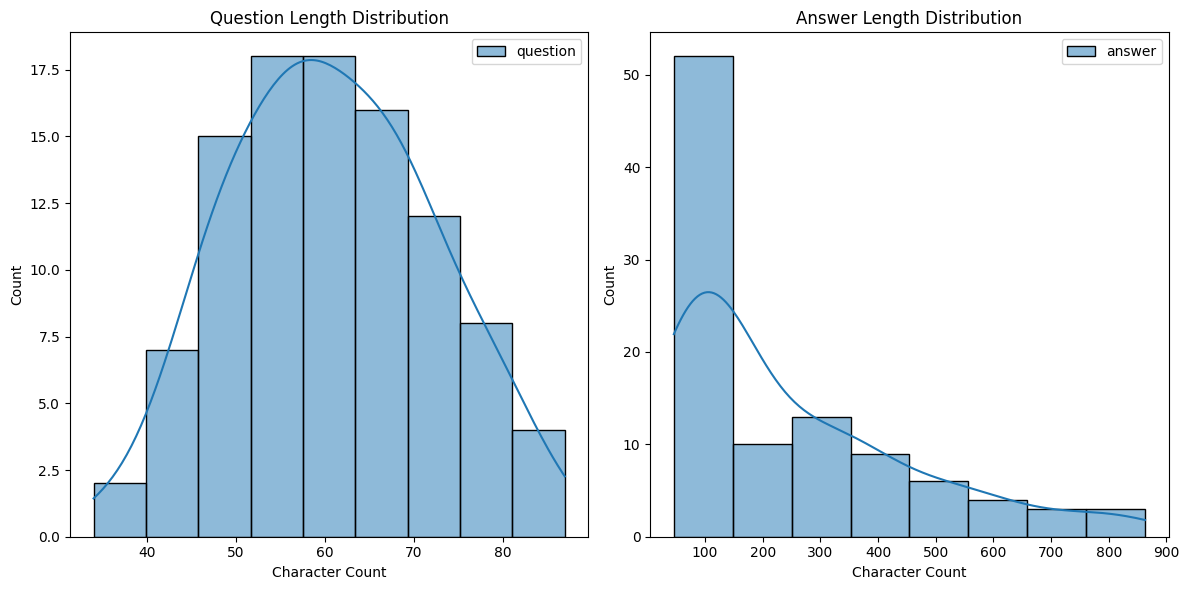


=== Word Count Analysis ===

question word count statistics:
count    100.000000
mean       9.830000
std        1.907216
min        5.000000
25%        9.000000
50%       10.000000
75%       11.000000
max       15.000000
Name: question_word_count, dtype: float64

answer word count statistics:
count    100.000000
mean      38.160000
std       31.535364
min        7.000000
25%       15.000000
50%       22.500000
75%       53.500000
max      130.000000
Name: answer_word_count, dtype: float64


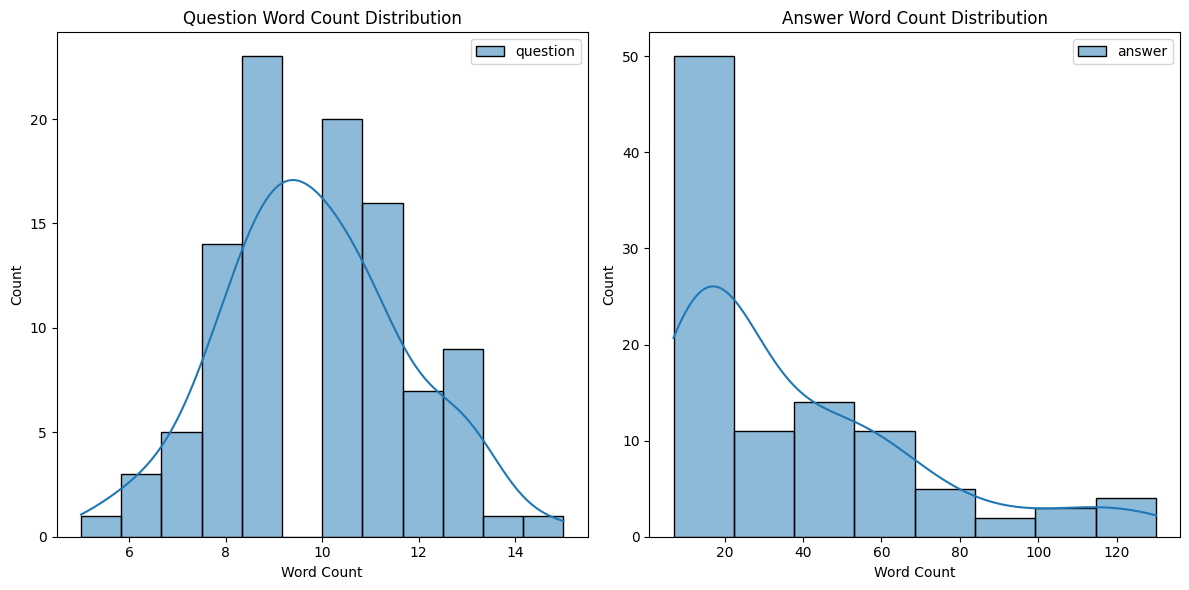

,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,How many incidents of 'Vehicle - Stolen' were ...,"There were no reported incidents of ""Vehicle -...",75,75,13,13
1,What is the total number of 'Burglary from Veh...,"The total number of ""Burglary from Vehicle"" ca...",87,88,15,15
2,In which LAPD area was 'Bike - Stolen' most fr...,"The LAPD area where ""Bike - Stolen"" was most f...",64,78,11,13
3,How many crimes occurred between 6:00 PM and 1...,"A total of 314,140 crimes occurred between 6:0...",71,81,13,15
4,What percentage of crimes involved the use of ...,100% of the crimes involved the use of a weapon.,55,48,10,10
...,...,...,...,...,...,...
95,How many incidents involve multiple charges (m...,"There are 1,005,198 incidents that involve mul...",79,107,11,15
96,Are certain crime types frequently reported to...,Certain crime types are frequently reported to...,79,805,11,112
97,How many incidents involved an attempted crime...,The incidents are categorized as follows:\n\n-...,70,435,11,59
98,How often do violent crimes involve more than ...,There are no recorded violent crime cases in t...,60,95,10,16


In [18]:
q_cols, a_cols = basic_statistics(df)
df = length_analysis(df, q_cols, a_cols)
df = word_count_analysis(df, q_cols, a_cols)
df


=== Question Type Analysis ===
Question columns: ['question']

Question types in question:
what: 34 (34.0%)
how: 36 (36.0%)
why: 0 (0.0%)
when: 0 (0.0%)
where: 0 (0.0%)
who: 0 (0.0%)
which: 19 (19.0%)
can: 0 (0.0%)
do: 0 (0.0%)
is: 1 (1.0%)
are: 10 (10.0%)
other: 0 (0.0%)


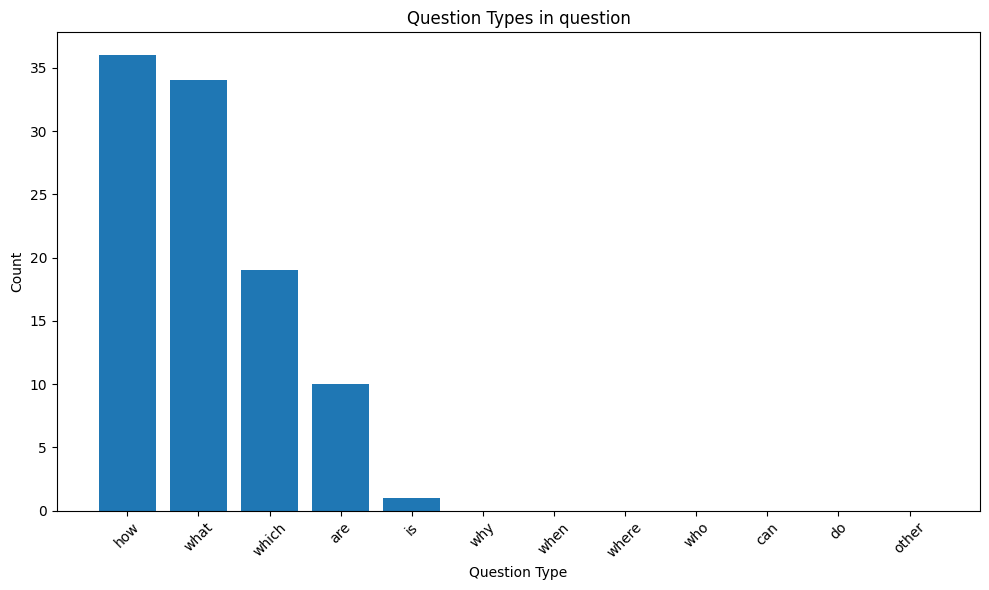

In [20]:
question_type_analysis(df, q_cols)


=== Common Words Analysis ===

=== Common Words Analysis for question ===

Most common words in question:
crimes: 32
crime: 24
many: 21
reported: 17
incidents: 11
common: 11
victims: 11
weapon: 10
highest: 10
area: 9
vehicle: 8
cases: 8
frequently: 7
involved: 7
thefts: 7
often: 7
number: 6
percentage: 6
date: 6
compared: 5


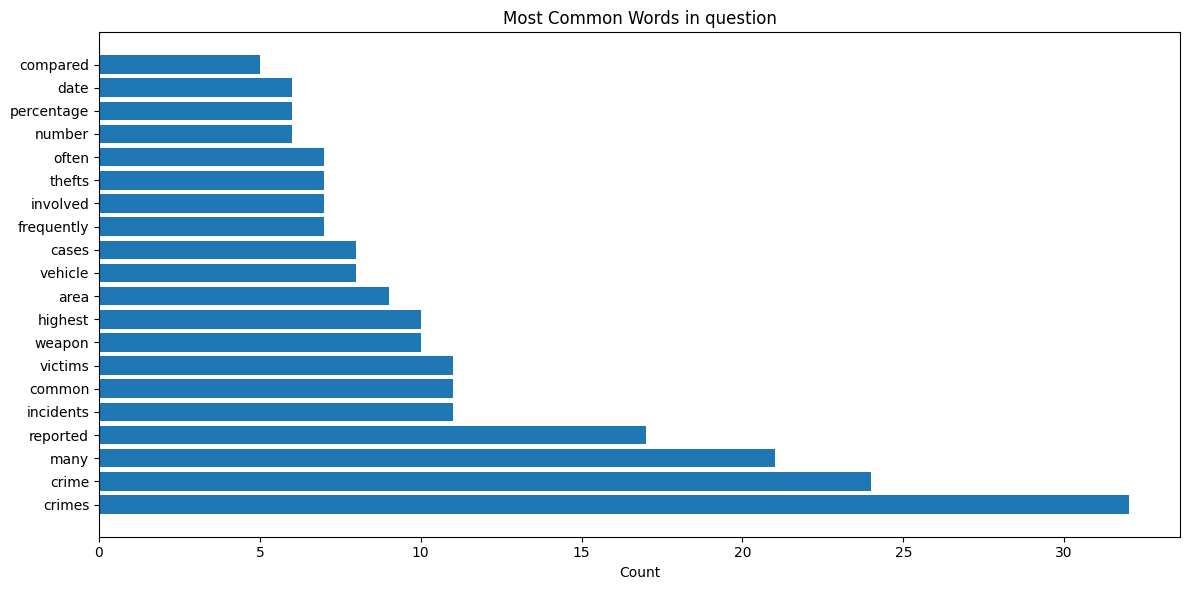


=== Common Words Analysis for answer ===

Most common words in answer:
crimes: 77
incidents: 63
occurrences: 51
thefts: 50
reported: 39
cases: 32
crime: 29
victims: 29
vehicle: 26
theft: 26
age: 26
victim: 22
reports: 22
assault: 21
weapon: 20
number: 18
burglary: 17
area: 17
pm: 17
average: 17


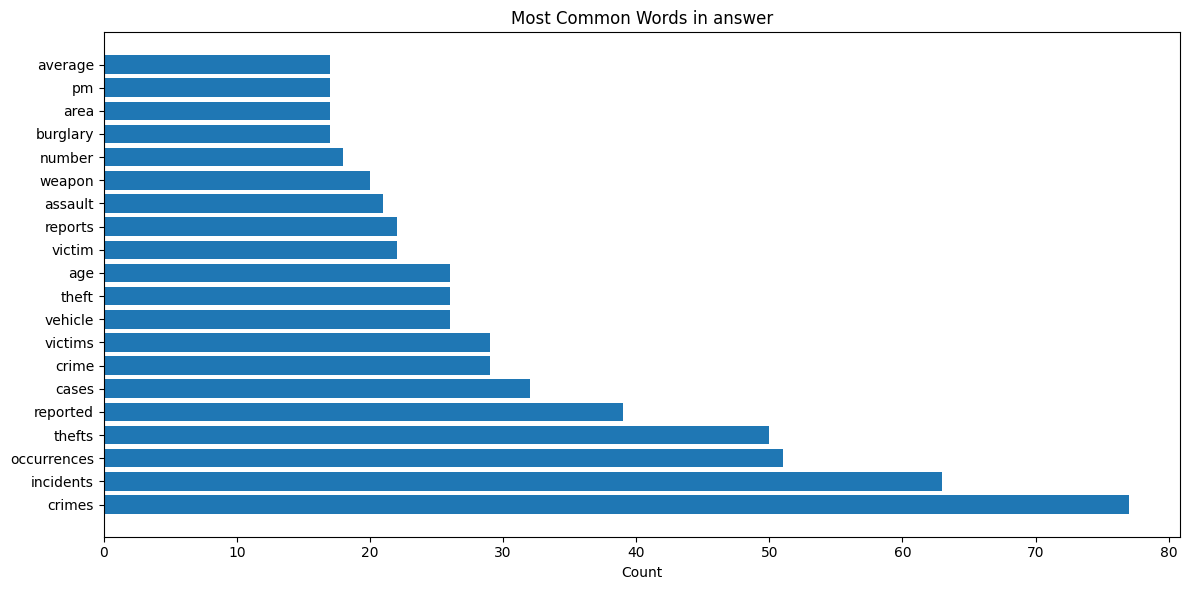

In [21]:
# nltk.download('stopwords')
# nltk.download('punkt')
common_words_analysis(df, q_cols, a_cols)


=== Correlation Analysis ===

Correlation Matrix:
                     question_length  answer_length  question_word_count  \
question_length             1.000000       0.200414             0.855412   
answer_length               0.200414       1.000000             0.076664   
question_word_count         0.855412       0.076664             1.000000   
answer_word_count           0.182613       0.987373             0.080734   

                     answer_word_count  
question_length               0.182613  
answer_length                 0.987373  
question_word_count           0.080734  
answer_word_count             1.000000  


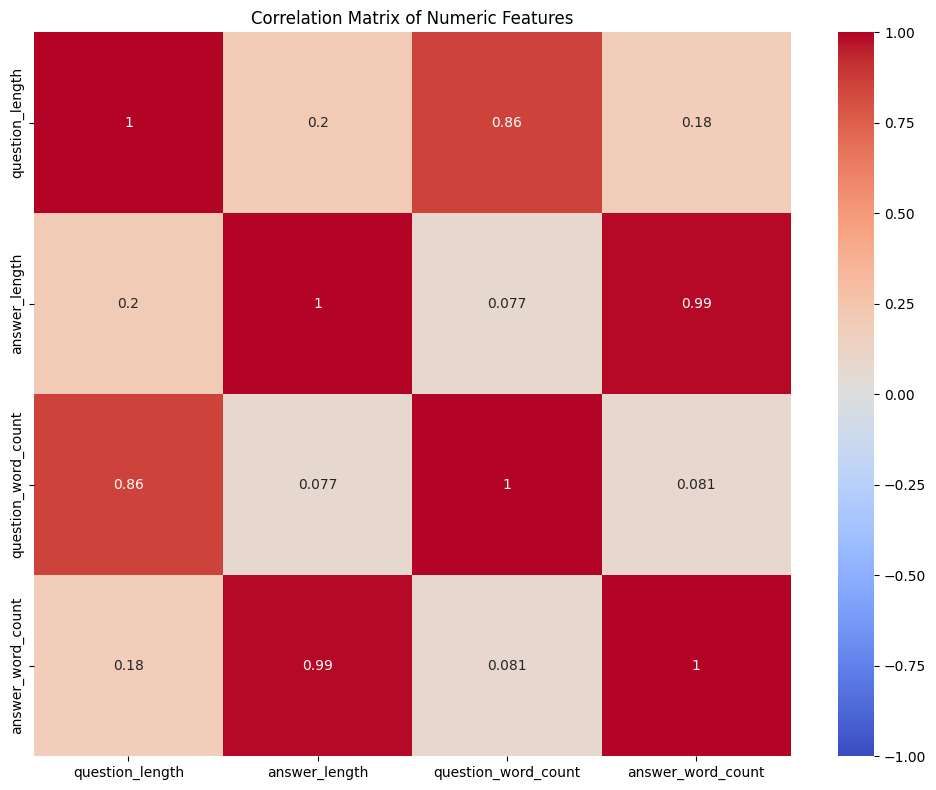

In [22]:
correlation_analysis(df)


=== Category Analysis ===
Categorical columns: ['question', 'answer']

Top categories in question:
question
How many incidents of 'Vehicle - Stolen' were reported in Wilshire in 2020?    1
Are burglaries more common in residential or commercial areas?                 1
Are crimes involving unknown perpetrators categorized differently?             1
What percentage of reports have missing location data (LAT/LON)?               1
How often are multiple victims recorded for one incident number (DR_NO)?       1
How many incidents list multiple crime codes?                                  1
Are there any new crime codes introduced in 2020?                              1
Which two crime codes are most closely linked together in incidents?           1
What crime code is associated with most 'Part 1' crimes?                       1
How many unique crime codes are represented in the dataset?                    1
Name: count, dtype: int64


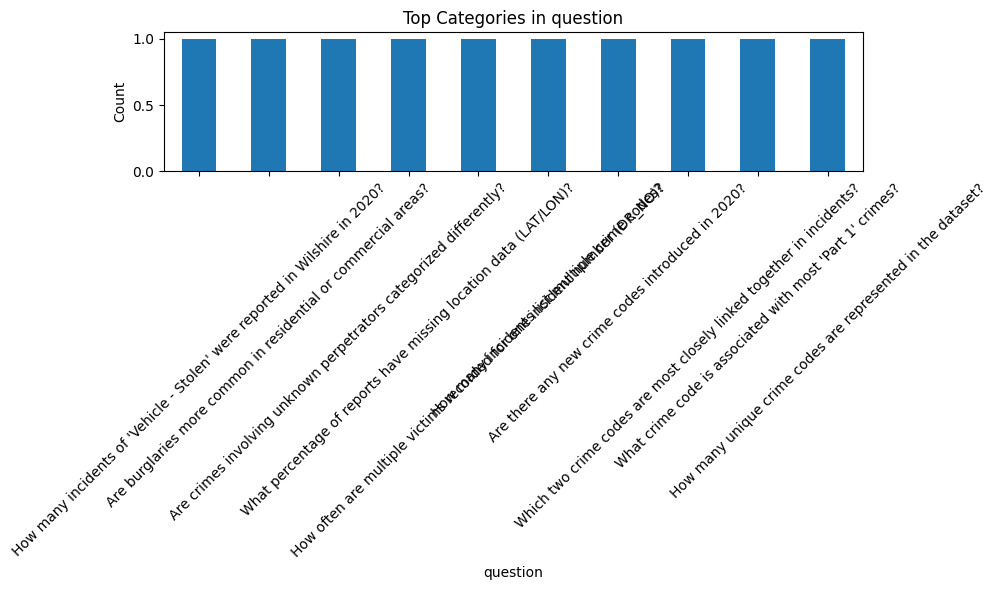


Top categories in answer:
answer
There were no reported incidents of "Vehicle - Stolen" in Wilshire in 2020.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         1
Burglaries are more common in residential areas compared to commercial ones. The most frequent locations for burglaries include:\n\n1. **Street**: 26,353 incidents\n2. **Single Family Dwelling**: 22,017 incidents\n3. **Parking Lot**: 14,767 incidents\n4. **Multi-Unit Dwelling (Apartment, Duplex, etc.)**: 11,185 incidents\n\nWhile commercial areas like "Other Busines

/tmp/ipykernel_84480/1309929593.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


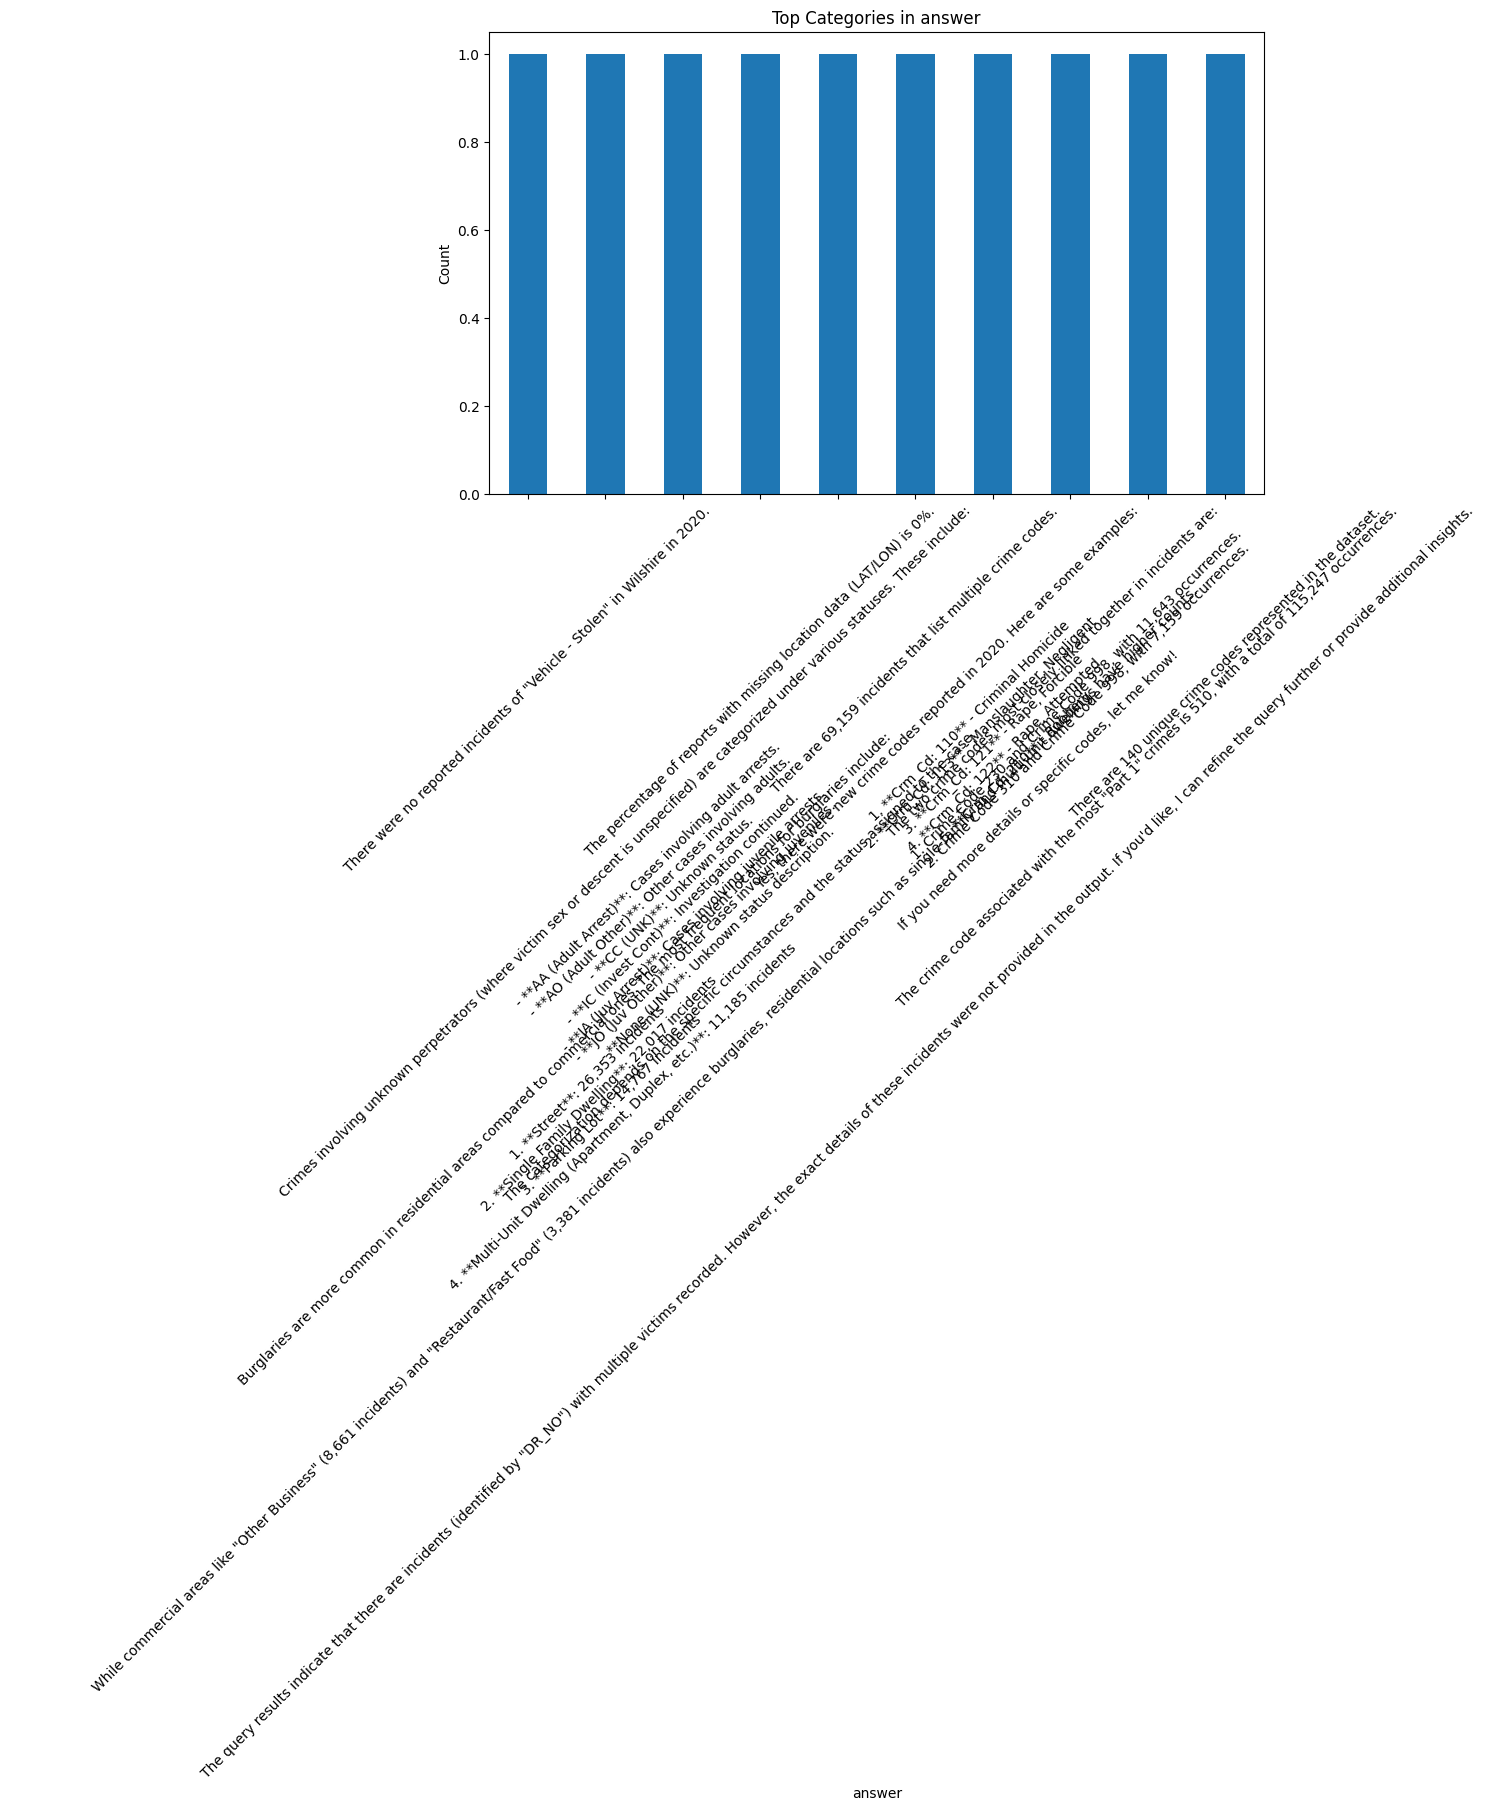

In [23]:
category_analysis(df)